# Predicting `crim` in `Boston` dataset

## Preparing the data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

boston = pd.read_csv('../../datasets/Boston.csv', index_col=0)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [2]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 1 to 506
Data columns (total 14 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
black      506 non-null float64
lstat      506 non-null float64
medv       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 59.3 KB


## a. Experimenting with different models

### Train test split

In [3]:
from sklearn.model_selection import train_test_split

# split original data
X_train, X_test, y_train, y_test = train_test_split(boston.drop(columns=['crim']), 
                                                            boston['crim'], train_size=0.7,
                                                            random_state=0)

# split normalized data
boston_norm = (boston - boston.mean()) / boston.std()
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(boston_norm.drop(columns=['crim']), 
                                                            boston_norm['crim'], train_size=0.7,
                                                            random_state=0)


X_train_n.shape, X_test_n.shape, y_train_n.shape, y_test_n.shape

/Users/home/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((354, 13), (152, 13), (354,), (152,))

In [4]:
X_train.head()

,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
142,0.0,21.89,0,0.624,5.019,100.0,1.4394,4,437,21.2,396.90,34.41,14.4
273,20.0,6.96,0,0.464,6.538,58.7,3.9175,3,223,18.6,394.96,7.73,24.4
136,0.0,21.89,0,0.624,6.335,98.2,2.1107,4,437,21.2,394.67,16.96,18.1
299,70.0,2.24,0,0.400,6.345,20.1,7.8278,5,358,14.8,368.24,4.97,22.5
123,0.0,25.65,0,0.581,5.961,92.9,2.0869,2,188,19.1,378.09,17.93,20.5


In [5]:
X_train_n.head()

,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
142,-0.487240,1.567444,-0.272329,0.598087,-1.801314,1.116390,-1.118693,-0.637331,0.170662,1.267684,0.440616,3.046737,-0.884279
273,0.370303,-0.608829,-0.272329,-0.782679,0.360603,-0.350810,0.058155,-0.752178,-1.099088,0.066730,0.419366,-0.689402,0.203020
136,-0.487240,1.567444,-0.272329,0.598087,0.071683,1.052444,-0.799893,-0.637331,0.170662,1.267684,0.416190,0.603123,-0.481978
299,2.514159,-1.296840,-0.272329,-1.334986,0.085915,-1.722091,1.915153,-0.522484,-0.298078,-1.688511,0.126688,-1.075899,-0.003567
123,-0.487240,2.115521,-0.272329,0.227006,-0.460613,0.864159,-0.811196,-0.867024,-1.306758,0.297683,0.234580,0.738957,-0.221027


### BSS model

#### Select best number of predictors with 10-fold cross-validation

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# dict for mse results
bss_mses = {'num_pred': [], 'best_pred_idx': [], 'best_cv_mse': []}

# get best subset of k predictors for k = 1,...,p
for k in range(1, X_train_n.shape[1] + 1):
    reg = LinearRegression()
    efs = EFS(reg, min_features=k, max_features=k, scoring='neg_mean_squared_error',
              print_progress=False, cv=10, n_jobs=-1)
    efs = efs.fit(X_train_n, y_train_n)
    bss_mses['num_pred'] += [k]
    bss_mses['best_pred_idx'] += [efs.best_idx_]
    bss_mses['best_cv_mse'] += [-efs.best_score_]
    
# data frame for results
bss_mses_df = pd.DataFrame(bss_mses)
bss_mses_df

,num_pred,best_pred_idx,best_cv_mse
0,1,"(7,)",0.614720
1,2,"(7, 11)",0.584325
2,3,"(0, 7, 11)",0.581228
3,4,"(0, 6, 7, 12)",0.575825
4,5,"(0, 1, 6, 7, 12)",0.570074
5,6,"(0, 1, 6, 7, 9, 12)",0.568879
6,7,"(0, 1, 3, 6, 7, 9, 12)",0.567485
7,8,"(0, 1, 3, 6, 7, 9, 11, 12)",0.567127
8,9,"(0, 1, 2, 3, 6, 7, 9, 11, 12)",0.567506
9,10,"(0, 1, 2, 3, 5, 6, 7, 9, 11, 12)",0.568090


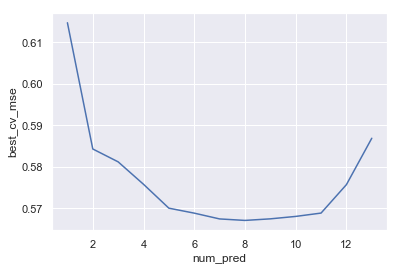

In [7]:
sns.lineplot(x=bss_mses_df['num_pred'], y=bss_mses_df['best_cv_mse'])

In [8]:
bss_final_model_df = bss_mses_df.loc[bss_mses_df['best_cv_mse'].idxmin(), :]
bss_final_model_df

num_pred                                  8
best_pred_idx    (0, 1, 3, 6, 7, 9, 11, 12)
best_cv_mse                        0.567127
Name: 7, dtype: object

#### Get test error

In [9]:
# helper function which creates a full length beta with zero entries for ommitted predictors
def full_beta(beta_len, model_beta, pred_idx):
    beta, counter = np.zeros(beta_len), 0
    for i in pred_idx:
        beta[i] = model_beta[counter]
        counter += 1
    return beta

# helper which predicts test data >= features of train data
def diff_num_feat_pred(estimator, X_train, y_train, X_test, pred_idx):
    if len(pred_idx) == 1:
        model_beta = estimator().fit(X_train[:, pred_idx].reshape(-1, 1), y_train).coef_
    else:
        model_beta = estimator().fit(X_train[:, pred_idx], y_train).coef_
    beta_len = X_test.shape[1]
    beta = full_beta(beta_len, model_beta, pred_idx)
    return np.matmul(X_test, beta)

In [10]:
from sklearn.metrics import mean_squared_error

pred_idx = bss_final_model_df['best_pred_idx']
X_train
y_pred = diff_num_feat_pred(LinearRegression, X_train.values, y_train, X_test, pred_idx)
bss_mse_test = mean_squared_error(y_test, y_pred)

mses_df = pd.DataFrame({'mse_test': bss_mse_test, 'params': [{'best_pred_idx': pred_idx}]},
                       index=['bss'])
mses_df

,mse_test,params
bss,345.136759,"{'best_pred_idx': (0, 1, 3, 6, 7, 9, 11, 12)}"


### Ridge Regression model

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

parameters = {'alpha': [10**i for i in range(-3, 4)]}
ridge_cv = GridSearchCV(Ridge(), parameters, cv=10, 
                     scoring='neg_mean_squared_error')

In [12]:
%%capture

ridge_cv.fit(X_train_n, y_train_n)

In [13]:
ridge_mse_test = mean_squared_error(y_test, ridge_cv.best_estimator_.predict(X_test))
mses_df = mses_df.append(pd.DataFrame({'mse_test': ridge_mse_test, 'params': [ridge_cv.best_params_]}, index=['ridge']))
mses_df

,mse_test,params
bss,345.136759,"{'best_pred_idx': (0, 1, 3, 6, 7, 9, 11, 12)}"
ridge,50.511281,{'alpha': 10}


### Lasso Regression model

In [17]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

parameters = {'alpha': [10**i for i in range(-3, 4)]}
lasso_cv = GridSearchCV(Lasso(), parameters, cv=10, 
                     scoring='neg_mean_squared_error')

In [18]:
%%capture

lasso_cv.fit(X_train_n, y_train_n)

In [19]:
lasso_mse_test = mean_squared_error(y_test, lasso_cv.best_estimator_.predict(X_test))
mses_df = mses_df.append(pd.DataFrame({'mse_test': lasso_mse_test, 'params': [lasso_cv.best_params_]}, index=['lasso']))
mses_df

,mse_test,params
bss,345.136759,"{'best_pred_idx': (0, 1, 3, 6, 7, 9, 11, 12)}"
ridge,50.511281,{'alpha': 10}
lasso,55.832052,{'alpha': 0.01}


### PCR model

In [20]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [21]:
pcr_mses = {'n_components': [], 'mse_test': []}

for i in range(1, X_train.shape[1] + 1):
    pca = PCA(n_components=i).fit(X_train)
    pcr = LinearRegression().fit(pca.transform(X_train), y_train)
    pcr_mses['n_components'] += [i]
    pcr_mses['mse_test'] += [-cross_val_score(pcr, 
                                              X=pca.transform(boston.drop(columns=['crim'])), 
                                              y=boston['crim'],
                                              scoring='neg_mean_squared_error',
                                              cv=10
                                              ).mean()
                             ]
pcr_mses_df = pd.DataFrame(pcr_mses)
pcr_mses_df

,n_components,mse_test
0,1,52.816816
1,2,60.853148
2,3,61.334721
3,4,61.446450
4,5,62.524405
5,6,58.173963
6,7,54.557999
7,8,52.706127
8,9,52.701465
9,10,51.970020


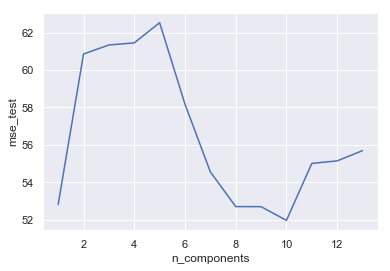

In [22]:
sns.lineplot(x=pcr_mses_df['n_components'], y=pcr_mses_df['mse_test'])

In [23]:
pcr_final_df = pcr_mses_df.iloc[pcr_mses_df['mse_test'].idxmin(), :]
pcr_final_df

n_components    10.00000
mse_test        51.97002
Name: 9, dtype: float64

In [24]:
mses_df = mses_df.append(pd.DataFrame({'mse_test': pcr_final_df['mse_test'], 
                                       'params': [{'n_components': pcr_final_df['n_components']}]}, 
                                       index=['pcr']))
mses_df

,mse_test,params
bss,345.136759,"{'best_pred_idx': (0, 1, 3, 6, 7, 9, 11, 12)}"
ridge,50.511281,{'alpha': 10}
lasso,55.832052,{'alpha': 0.01}
pcr,51.970020,{'n_components': 10.0}


### b. The chosen model

The test error of all models was estimated using 10-fold cross validation. The Ridge, Lasso, and PCR models all had dramatically better test error than the BSS model. 

The comparable test error estimates of these models suggest that any of these would be a good choice. However, since Ridge had the best test error we propose this as the final model choice.

### c. Does this chosen model involve all of the features?

We'll need to check the parameters estimates to see if any are zero

In [26]:
alpha = ridge_cv.fit(X_train, y_train).best_params_['alpha']
ridge = Ridge(alpha=alpha).fit(X_train, y_train)
ridge.coef_

/Users/home/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


array([ 3.84143511e-02, -1.06250131e-01, -1.73225646e-01, -7.62914551e-02,
        5.38270606e-01, -1.66925727e-02, -6.96483300e-01,  5.49989757e-01,
       -3.12204302e-03, -2.02578937e-01,  4.15559037e-04,  1.98319611e-01,
       -1.81963777e-01])

Some values are small, but none are totally negligible. So the final model does involve all the features